<h1><center> Seaside Building Optimization </center></h1>
This code performs a multi-hazard damage analysis and optimization of building mitigation options for Seaside, Oregon.


This notebook consists of the following sections:
+ [Importing modules and defining recurrence interval](#input)
+ [Multi-Hazard damage analysis](#dmg_analysis)
  + [Direct economic loss computations](#econ_loss)
  + [Repair time estimates](#repair)
  + [Population dislocation estimates](#disloc)
+ [Optimization](#optimization)
  + [Data aggregation](#agg-opt)
  + [Optimal solution search](#optimal_search)
+ [Plotting Results](#plotting)


The mitigation options that are considered at each parcel are:

| Mitigation option | Description |
| --- | --- |
| 0 | Do nothing / Status Quo | 
| 1 | Retrofit structure to high code |
| 2 | Relocate structure outside the inundation zone | 
| 3 | Decrease repair time | 

*Notebook developed by [Tarun Adluri](https://www.linkedin.com/in/tarunadluri) and [Dylan Sanderson](https://github.com/22dylan)

<a id='input'></a>
***
### Importing modules and defining recurrence interval


In [36]:
import os
import pandas as pd
import geopandas as gpd
import contextily as ctx
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,20

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.cumulativebuildingdamage import CumulativeBuildingDamage
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
client = IncoreClient()

Connection successful to IN-CORE services. pyIncore version detected: 0.9.0


#### Specifying recurrence interval to consider

| Recurrence Intervals Options |
| --- | 
| 100 |  
| 250 | 
| 500 |  
| 1,000 |
| 2,500 |
| 5,000 |
| 10,000 |

In [137]:
event = int(input("Select hazard return period in years (e.g. 500): "))

Select hazard return period in years (e.g. 500): 1000


##### Specifiying pyIncore hazard information

In [138]:
earthquake_hazard_dict = {100: "5dfa4058b9219c934b64d495", 
                          250: "5dfa41aab9219c934b64d4b2",
                          500: "5dfa4300b9219c934b64d4d0",
                          1000: "5dfa3e36b9219c934b64c231",
                          2500: "5dfa4417b9219c934b64d4d3", 
                          5000: "5dfbca0cb9219c101fd8a58d",
                         10000: "5dfa51bfb9219c934b68e6c2"}

tsunami_hazard_dict = {100: "5bc9e25ef7b08533c7e610dc", 
                      250: "5df910abb9219cd00cf5f0a5",
                      500: "5df90e07b9219cd00ce971e7",
                      1000: "5df90137b9219cd00cb774ec",
                      2500: "5df90761b9219cd00ccff258",
                      5000: "5df90871b9219cd00ccff273",
                      10000: "5d27b986b9219c3c55ad37d0"}

# creating path to damage output
path_to_dmg = os.path.join(os.getcwd(), 'damage_results_{}yr'.format(event))
if not os.path.exists(path_to_dmg):
    os.makedirs(path_to_dmg)

# creating path to dislocation output
path_to_dislocation = os.path.join(os.getcwd(), 'dislocation_results_{}yr'.format(event))   
if not os.path.exists(path_to_dislocation):
    os.makedirs(path_to_dislocation)

<a id='dmg_analysis'></a>
***
<h2><center> Multi-hazard damage analysis </center><h2>

##### Earthquake building damage

In [139]:
# initializing building damage and fragility service
bldg_dmg = BuildingDamage(client)   
fragility_service = FragilityService(client)

# defining building dataset (GIS point layer)
bldg_dataset_id = "5df40388b9219c06cf8b0c80"
bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)

retrofit_mapping_ids = ["5d2789dbb9219c3c553c7977", 
                        "5e99d145f2935b00011900a4"]

for retrofit_i in range(len(retrofit_mapping_ids)):
    # specifiying mapping id from fragilites to building types
    mapping_id = retrofit_mapping_ids[retrofit_i]
    mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
    bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

    bldg_dmg.set_parameter("hazard_type", "earthquake")
    bldg_dmg.set_parameter("num_cpu", 4)

    result_name = os.path.join(path_to_dmg, 'buildings_eq_{}yr_opt{}' .format(event, retrofit_i))
    hazard_id = earthquake_hazard_dict[event]
    bldg_dmg.set_parameter("hazard_id", hazard_id)
    bldg_dmg.set_parameter("result_name", result_name)

    bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


##### Tsunami building damage
First running through pyIncore code

In [140]:
# initializing building damage and fragility service
bldg_dmg = BuildingDamage(client)   
fragility_service = FragilityService(client)

# defining building dataset (GIS point layer)
bldg_dataset_id = "5df40388b9219c06cf8b0c80"
bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)

# --- running through tsunami building damage with status quo options
# specifiying mapping id from fragilites to building types

mapping_id = "5d279bb9b9219c3c553c7fba"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

bldg_dmg.set_parameter("hazard_type", "tsunami")
bldg_dmg.set_parameter("num_cpu", 4)

result_name = os.path.join(path_to_dmg, 'buildings_tsu_{}yr_opt0' .format(event))
hazard_id = tsunami_hazard_dict[event]
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("result_name", result_name)

bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

Now, creating output with relocated structures (i.e. tsunami damage is None)

In [141]:
tsu_data = os.path.join(path_to_dmg, 'buildings_tsu_{}yr_opt0.csv' .format(event))
df = pd.read_csv(tsu_data)
df['DS_0'] = 1
df['DS_1'] = 0
df['DS_2'] = 0
df['DS_3'] = 0
df['LS_0'] = 0
df['LS_1'] = 0
df['LS_2'] = 0

path_out = os.path.join(path_to_dmg, 'buildings_tsu_{}yr_opt1.csv' .format(event))
df.to_csv(path_out, index=False)

##### Multi-hazard damage analysis

| Mitigation option | Description | Earthquake | Tsunami |
| --- | --- | --- | --- |
| 0 | Do nothing / Status Quo | Status Quo | Status Quo | 
| 1 | Retrofit structure to high code | Opt1 | Status Quo |
| 2 | Relocate structure outside the inundation zone | Status Quo | Opt1 |
| 3 | Decrease repair time | Status Quo | Status Quo |

In [142]:
cumulative_scenarios = [
    ['buildings_eq_{}yr_opt0.csv' .format(event), 'buildings_tsu_{}yr_opt0.csv' .format(event)],
    ['buildings_eq_{}yr_opt1.csv' .format(event), 'buildings_tsu_{}yr_opt0.csv' .format(event)],
    ['buildings_eq_{}yr_opt0.csv' .format(event), 'buildings_tsu_{}yr_opt1.csv' .format(event)],
    ['buildings_eq_{}yr_opt0.csv' .format(event), 'buildings_tsu_{}yr_opt0.csv' .format(event)]
]


cumulative_bldg_dmg = CumulativeBuildingDamage(client)

for i in range(len(cumulative_scenarios)):
    pth_to_eq = cumulative_scenarios[i][0]
    pth_to_tsu = cumulative_scenarios[i][1]
    pth_to_eq = os.path.join(path_to_dmg, pth_to_eq)
    pth_to_tsu = os.path.join(path_to_dmg, pth_to_tsu)
    
    # --- running pyIncore
    cumulative_bldg_dmg.set_parameter("num_cpu", 1)

    # loading datasets from CSV files into pyincore
    eq_damage_dataset = Dataset.from_file(pth_to_eq, "ergo:buildingDamageVer5")
    tsu_damage_dataset = Dataset.from_file(pth_to_tsu, "ergo:buildingDamageVer5")

    cumulative_bldg_dmg.set_input_dataset("eq_bldg_dmg", eq_damage_dataset)
    cumulative_bldg_dmg.set_input_dataset("tsunami_bldg_dmg", tsu_damage_dataset)

    # defining path to output 
    result_name = os.path.join('buildings_cumulative_{}yr_opt{}' .format(event, i))
    result_name = os.path.join(path_to_dmg, result_name)
    
    cumulative_bldg_dmg.set_parameter("result_name", result_name)

    # running analysis
    cumulative_bldg_dmg.run_analysis()
    

##### Removing individual hazard results
We only care about the multi-hazard case and don't wont too many files hanging around

In [143]:
if os.path.isdir(path_to_dmg):
    for file in os.listdir(path_to_dmg):
        if not "cumulative" in file:
            file = os.path.join(path_to_dmg, file)
            os.remove(file)

<a id='econ_loss'></a>
***
### Direct economic loss computations
Computing economic losses based on expected damage state and 

In [144]:
dmg_rto = [0.005, 0.155, 0.55, 0.90]  # from MAEVIS documentation (damage ratio)

# reading in rmv values of each building
bldg_dataset_id = "5df40388b9219c06cf8b0c80"
data_service = DataService(client)
dataset = Dataset.from_data_service(bldg_dataset_id, data_service)
rd = dataset.get_inventory_reader()


struct_typ, guid, rmv, year_built = [], [], [], []
for row in rd:
    guid.append(row['properties']['guid'])
    rmv.append(row['properties']['rmv_improv'])
    year_built.append(row['properties']['year_built'])
    struct_typ.append(row['properties']['struct_typ'])
df = pd.DataFrame({'guid': guid, 'rmv': rmv, 'year_built': year_built,'struct_typ':struct_typ})
df.set_index('guid', inplace=True)

DS_keys = ['DS_0', 'DS_1', 'DS_2', 'DS_3']
for file in os.listdir(path_to_dmg):
    
    # reading in the results
    file = os.path.join(path_to_dmg, file)
    df_temp = pd.read_csv(file)
    df_temp.set_index('guid', inplace=True)
    
    # adding real market value column to results if it's not already there
    if not 'rmv' in list(df_temp.columns):
        df_temp = pd.merge(df_temp, df, left_index=True, right_index=True)
    
    # computing expected direct economic losses if they do not exist
    if not 'econ_loss' in list(df_temp.columns):
        df_temp['econ_loss'] = (df_temp[DS_keys]*dmg_rto).sum(axis=1)*df_temp['rmv']      
    
    # computing expected direct economic losses if they do not exist
    if not 'year_built' in list(df_temp.columns):
        df_temp['year_built'] = df['year_built']
        df_temp['year_built'].replace([0,1,200,2203], 1960)
        
    # writing back to output
    df_temp.to_csv(file)


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


<a id='repair'></a>
***
### Repair time estimates
+ Building repair time information is taken from [HAZUS MH 2.1 (Earthquake Model)](https://www.fema.gov/sites/default/files/2020-09/fema_hazus_earthquake-model_technical-manual_2.1.pdf#page=613)  Section 15.2.4.
+ HAZUS provides the median values for repair times for each damage state and building type.
+ The repair time formulation follows [Kameshwar et al. (2019)](https://www.sciencedirect.com/science/article/pii/S0951832018315163?casa_token=CPiMJq2o8zAAAAAA:Hjr5X2tu2MWfcEG57JVwAMrn9QgiInDG_eoPsUAQXdZJ7VgaI3UyXVqILpD92IPTVG50R5MsaVA), in which only one set of repair time estimates are used for both earthquake and tsunami hazards and across building types.
+ Kameshwar et al. (2019) assume that a lognormal restoration model is used for buildings and that the logarithmic dispersion is 0.5.
+ Because Monte-Carlo simulation is not implemented for the optimization algorithm, the median values provided by HAZUS that are used to parameterize the lognormal restoration functions are converted to [mean values](https://www.itl.nist.gov/div898/handbook/apr/section1/apr164.htm)


| Damage State | Median | Dispersion |
| --- | --- | --- |
| Insignificant/None | 0.5 | 0.5 |
| Moderate | 60 | 0.5 |
| Heavy | 360 | 0.5 |
| Complete | 720 | 0.5 |

The repair time is thus computed as <br>
$$Repair = \sum_{ds} P_{ds} \mu_{r,ds}$$
With 
+ $P_{ds}$: probability of being in damage state $ds$
+ $\mu_{r,ds}$: mean repair time associated with damage state $ds$

In [145]:
# median repair times for DS: None, slight, moderate, extensive, and complete
med = np.array([0.5, 60, 360, 720])
beta = np.array([0.5, 0.5, 0.5, 0.5])
DSs = ['DS_0', 'DS_1', 'DS_2', 'DS_3']

# converting median/beta to mean values
mean_repair_time = med*np.exp((beta**2)/2)

In [146]:
DS_keys = ['DS_0', 'DS_1', 'DS_2', 'DS_3']
cnt = 0
for file in os.listdir(path_to_dmg):
    
    # if mitigation option 3, decrease repair time by half
    if cnt == 3:
        mean_repair_time = 0.5*mean_repair_time

    # reading in the results
    file = os.path.join(path_to_dmg, file)
    df_temp = pd.read_csv(file)
    df_temp.set_index('guid', inplace=True)
    
    # computing repair times if they do not exist
    if not 'repair' in list(df_temp.columns):
        df_temp['repair'] = (df_temp[DS_keys]*mean_repair_time).sum(axis=1)      

    df_temp.to_csv(file)
    cnt += 1


## Initial Interdependent Community Description - Seaside, OR

Explore building inventory and social systems. Specifically look at how the building inventory connects with the housing unit inventory using the housing unit allocation.
The housing unit allocation method will provide detail demographic characteristics for the community allocated to each structure.

In [147]:
# Seaside Housing Unit Inventory
housing_unit_inv_id = "5d543087b9219c0689b98234"
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\TarunAdluri\.incore\cache_data\5d543087b9219c0689b98234\IN-CORE_1bv6_SetupSeaside_FourInventories_2019-08-02_HUinventory\IN-CORE_1bv6_SetupSeaside_FourInventories_2019-08-02_HUinventory.csv


In [148]:
address_point_inv_id = "5d542fefb9219c0689b981fb"

In [149]:
building_inv = Dataset.from_file("IN-CORE_Seaside_BuildingInventory_2021-03-20.shp", data_type='ergo:buildingInventoryVer6')

In [150]:
bldg_inv_gdf = gpd.read_file("IN-CORE_Seaside_BuildingInventory_2021-03-20.shp")
bldg_inv_gdf.head()

,parid,parid_card,bldg_id,struct_typ,str_prob,year_built,no_stories,a_stories,b_stories,bsmt_type,...,stat_class,rmv_improv,rmv_land,elev,period,strctid,x,y,value_matc,geometry
0,None,None,None,W1,None,1968,1,None,None,None,...,193,0.0,0.0,-1.037119,0.35,41007020933038031S,-123.908997,46.014336,0,POINT (-123.90900 46.01433)
1,None,None,None,W1,None,1992,1,None,None,None,...,193,0.0,0.0,-14.826966,0.35,41007022416079053S,-123.905846,45.997948,0,POINT (-123.90585 45.99795)
2,None,None,None,W1,None,1974,1,None,None,None,...,191,0.0,0.0,-1.037119,0.35,41007020933038014S,-123.908997,46.014336,0,POINT (-123.90900 46.01433)
3,None,None,None,W1,None,1984,1,None,None,None,...,193,0.0,0.0,-1.037119,0.35,41007020933038018S,-123.908997,46.014336,0,POINT (-123.90900 46.01433)
4,None,None,None,W1,None,1964,1,None,None,None,...,190,0.0,0.0,-1.729172,0.35,41007022789002002S,-123.911827,45.997475,0,POINT (-123.91183 45.99747)


## Run Housing Unit Allocation 
https://github.com/IN-CORE/incore-docs/blob/master/notebooks/housingunitallocation.ipynb

Rosenheim, Nathanael, Roberto Guidotti, Paolo Gardoni & Walter Gillis Peacock. (2019). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure. doi.org/10.1080/23789689.2019.1681821

In [151]:
from pyincore.analyses.housingunitallocation import HousingUnitAllocation

# Create housing allocation 
hua = HousingUnitAllocation(client)

# Load input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv_id)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv_id)
#hua.load_remote_input_dataset("buildings", bldg_inv_id)
hua.set_input_dataset("buildings", building_inv)

# Specify the result name
result_name = "Seaside_HUA"

seed = 1238
iterations = 1

# Set analysis parameters
hua.set_parameter("result_name", result_name)
hua.set_parameter("seed", seed)
hua.set_parameter("iterations", iterations)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [152]:
# Run Housing unit allocation analysis
hua.run_analysis()

True

In [153]:
# Retrieve result dataset
hua_result = hua.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
hua_df = hua_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
hua_df[['guid','numprec','ownershp','geometry','aphumerge']].head()

,guid,numprec,ownershp,geometry,aphumerge
0,e38d8575-7880-4a8c-b6d7-225ab1cf9264,2.0,1.0,POINT (-123.8960661064165 46.01272230816045),both
1,af5771b4-4f42-4166-b772-78a3706fa8ac,1.0,1.0,POINT (-123.9034265041881 46.01749849919388),both
2,37532fb5-5107-478b-ab2c-158eb001c68b,4.0,1.0,POINT (-123.9034265041881 46.01749849919388),both
3,66d39314-1c68-4634-a82c-8fcb37f529ff,3.0,1.0,POINT (-123.9002451964179 46.01352343272472),both
4,e519ec32-c5eb-422a-be3d-7ff4bb33f1e2,2.0,1.0,POINT (-123.8989178756465 46.01225606771315),both


In [154]:
hua_df.guid.describe()

count                                     6980
unique                                    4679
top       a698bf89-e06b-4d88-8116-81037737919b
freq                                        66
Name: guid, dtype: object

In [155]:
hua_df.huid.describe()

count                    21579
unique                   21579
top       B410079507002033H012
freq                         1
Name: huid, dtype: object

In [156]:
# keep observations where the housing unit characteristics have been allocated to a structure.
hua_df = hua_df.dropna(subset=['guid'])

In [157]:
hua_df.huid.describe()

count                     4741
unique                    4741
top       B410079509001022H015
freq                         1
Name: huid, dtype: object

In [158]:
hua_df['Race Ethnicity'] = "0 Vacant HU No Race Ethnicity Data"
hua_df['Race Ethnicity'].notes = "Identify Race and Ethnicity Housing Unit Characteristics."

hua_df.loc[(hua_df['race'] == 1) & 
                        (hua_df['hispan'] == 0),'Race Ethnicity'] = "1 White alone, Not Hispanic"
hua_df.loc[(hua_df['race'] == 2) & 
                        (hua_df['hispan'] == 0),'Race Ethnicity'] = "2 Black alone, Not Hispanic"
hua_df.loc[(hua_df['race'].isin([3,4,5,6,7])) & 
                        (hua_df['hispan'] == 0),'Race Ethnicity'] = "3 Other Race, Not Hispanic"
hua_df.loc[(hua_df['hispan'] == 1),'Race Ethnicity'] = "4 Any Race, Hispanic"
hua_df.loc[(hua_df['gqtype'] >= 1),'Race Ethnicity'] = "5 Group Quarters no Race Ethnicity Data"

hua_df['Tenure Status'] = "0 No Tenure Status"
hua_df.loc[(hua_df['ownershp'] == 1),'Tenure Status'] = "1 Owner Occupied"
hua_df.loc[(hua_df['ownershp'] == 2),'Tenure Status'] = "2 Renter Occupied"
hua_df['Tenure Status'].notes = "Identify Tenure Status Housing Unit Characteristics."

In [159]:
table = pd.pivot_table(hua_df, values='numprec', index=['Race Ethnicity'],
                                     margins = True, margins_name = 'Total',
                                     columns=['Tenure Status'], aggfunc=[np.sum]).rename(
    columns={'Total': 'Total Population', 'sum': ''})
table_title = "Table 1. Total Population by Race, Ethncity, and Tenure Status, Joplin, MO, 2010."
varformat = {('','Total Population'): "{:,.0f}",
             ('','0 No Tenure Status'): "{:,.0f}",
             ('','1 Owner Occupied'): "{:,.0f}",
             ('','2 Renter Occupied'): "{:,.0f}"}
table.style.set_caption(table_title).format(varformat)

## Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

https://data.census.gov/cedsci/table?q=DECENNIALPL2010.P1&g=1600000US4165950&tid=DECENNIALSF12010.P1

Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation results will become the input for the dislocation model.

In [160]:
# Save cleaned HUA file as CSV
hua_df.to_csv('IN-CORE_1cv1_housingunitallocation_1238.csv')

In [161]:
housing_unit_alloc = Dataset.from_file('IN-CORE_1cv1_housingunitallocation_1238.csv','incore:housingUnitAllocation')

In [162]:
# Seaside, OR Housing unit allocation, performed at start of notebook
housing_unit_alloc = Dataset.from_file('IN-CORE_1cv1_housingunitallocation_1238.csv','incore:housingUnitAllocation')

# Seaside, OR "IN-CORE_1bv6_SetupSeaside_FourInventories_2019-08-02_bgdata.csv"
bg_data = "5d542bd8b9219c0689b90408"

# Value loss parameters, "IN-CORE_value_loss_bai09.csv"
value_loss = "60354810e379f22e16560dbd"


<a id='disloc'></a>
***
### Population dislocation estimates

In [163]:
pop_dis = PopulationDislocation(client)
seed = 1111
cnt = 0
for file in os.listdir(path_to_dmg):

    #Reading in local building damage files
    file = os.path.join(path_to_dmg, file)
    dmg_data = Dataset.from_file(file, data_type='ergo:buildingDamageVer5')
    pop_dis.set_input_dataset("building_dmg", dmg_data)

    # loading remote population dislocation data 
    pop_dis.set_input_dataset("housing_unit_allocation", housing_unit_alloc)
    pop_dis.load_remote_input_dataset("block_group_data", "5d542bd8b9219c0689b90408")
    pop_dis.load_remote_input_dataset("value_poss_param", "60354810e379f22e16560dbd") 

    # setting population dislocation run information
    result_name = "housing-dislocation-result-opt{}".format(cnt)
    result_name = os.path.join(path_to_dislocation, result_name)
    pop_dis.set_parameter("result_name", result_name)
    pop_dis.set_parameter("seed", seed)
    
    # running population dislocation
    pop_dis.run_analysis()
    
    # reading 
    df = pd.read_csv('{}.csv' .format(result_name))
    df.dislocated = df.dislocated.astype("int32")
    df=df[df['numprec'].notna()]        
    #df.dropna(inplace=True)
    df = df.drop_duplicates(subset=['guid'])
    df.to_csv(result_name+".csv", index=False)
    cnt += 1

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [164]:
dmg_files = os.listdir(path_to_dmg)
dslc_files = os.listdir(path_to_dislocation)

for i in range(4):
    dmg_file = os.path.join(path_to_dmg, dmg_files[i])
    dmg_df = pd.read_csv(dmg_file)
    dmg_df.set_index('guid', inplace=True)
    b=['dislocated','numprec','prdis']
    for a in b:
    
        if not a in list(dmg_df.columns):
            dslc_file = os.path.join(path_to_dislocation, dslc_files[i])
            dslc_df = pd.read_csv(dslc_file)
            dslc_df.set_index('guid', inplace=True)    
            dmg_df = pd.merge(dmg_df, dslc_df[a], how='left', left_index=True, right_index=True)

            dmg_df.to_csv(dmg_file, index=True)

##### Removing population dislocation results
This data has been compiled into the damage anlaysis files

In [165]:
if os.path.isdir(path_to_dislocation):
    for file in os.listdir(path_to_dislocation):
        file = os.path.join(path_to_dislocation, file)
        os.remove(file)
    os.rmdir(path_to_dislocation)

*** 
<a id='optimization'></a>
<h2><center> Optimization </center><h2>

<a id='agg-opt'></a>
***
### Data aggregation

In [166]:
level0 = pd.read_csv("damage_results_{}yr/buildings_cumulative_{}yr_opt0.csv".format(event,event))
level0["K"]= 0
level0["dislocationcount"] = level0.numprec*level0.prdis  ##Expected Value of dislocation
level0["truedislocationcount"] = level0.numprec*level0.dislocated  #True Value of dislocation
level0["b"]=1
level1 = pd.read_csv("damage_results_{}yr/buildings_cumulative_{}yr_opt1.csv".format(event,event))
level1["K"]= 1
level1["b"]=0
level1["dislocationcount"] = level1.numprec*level1.prdis
level1["truedislocationcount"] = level1.numprec*level1.dislocated
level2 = pd.read_csv("damage_results_{}yr/buildings_cumulative_{}yr_opt2.csv".format(event,event))
level2["K"]= 2
level2["b"]=0
level2["dislocationcount"] = level2.numprec*level2.prdis
level2["truedislocationcount"] = level2.numprec*level2.dislocated
level3 = pd.read_csv("damage_results_{}yr/buildings_cumulative_{}yr_opt3.csv".format(event,event))
level3["K"]= 3
level3["b"]=0
level3["dislocationcount"] = level3.numprec*level3.prdis
level3["truedislocationcount"] = level3.numprec*level3.dislocated
level0.fillna(0, inplace=True)
level1.fillna(0, inplace=True)
level2.fillna(0, inplace=True)
level3.fillna(0, inplace=True)
print(level1[['guid', 'dislocated']].head())

                                   guid  dislocated
0  fba4c73f-9b1b-4942-b7fb-bc276a4e0a4e         0.0
1  65d6e370-c05b-4b2f-bd17-d914d1d056c7         0.0
2  dad76485-9694-409e-ac7f-c64c7bd5c32c         0.0
3  6f57cfb6-d244-40d5-96f5-03aeddd5e30a         1.0
4  929f1040-6224-409d-b4e3-58946daf3b91         0.0


In [167]:
ss_all_lvls = pd.concat([level0, level1, level2, level3])
ss_all_lvls = ss_all_lvls.groupby(["guid", "struct_typ", "K"]).mean().reset_index()
ss_all_lvls

,guid,struct_typ,K,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,rmv,year_built,econ_loss,repair,dislocated,numprec,prdis,dislocationcount,truedislocationcount,b
0,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,0,0.565613,0.153034,0.021198,0.434387,0.412580,0.131836,0.021198,184363.0,2005,29075.783640,99.371696,0.0,4.0,0.471463,1.885852,0.0,1
1,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,1,0.484637,0.084369,0.004712,0.515363,0.400268,0.079658,0.004712,184363.0,2005,20772.282216,63.844892,0.0,4.0,0.441119,1.764478,0.0,0
2,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,2,0.565613,0.153034,0.021198,0.434387,0.412580,0.131836,0.021198,184363.0,2005,29075.783640,99.371696,0.0,4.0,0.471463,1.885852,0.0,0
3,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,3,0.565613,0.153034,0.021198,0.434387,0.412580,0.131836,0.021198,184363.0,2005,29075.783640,49.685848,0.0,4.0,0.471463,1.885852,0.0,0
4,0004321a-e6dc-48af-80bd-f06f376110a7,W2,0,0.664812,0.213456,0.052464,0.335188,0.451356,0.160992,0.052464,36330.0,1939,7534.822181,139.354903,1.0,2.0,0.490402,0.980803,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18711,ffedfa6e-8b4d-4135-bda2-26c35243dc3d,W2,3,0.998345,0.996283,0.995602,0.001655,0.002062,0.000681,0.995602,68480.0,1912,61409.046170,406.348825,0.0,1.0,0.771408,0.771408,0.0,0
18712,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,0,0.997691,0.994567,0.992928,0.002309,0.003125,0.001639,0.992928,137021.0,1946,122638.238666,810.979389,1.0,2.0,0.778249,1.556499,2.0,1
18713,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,1,0.996675,0.993101,0.992449,0.003325,0.003574,0.000652,0.992449,137021.0,1946,122515.050481,810.217233,1.0,2.0,0.777740,1.555479,2.0,0
18714,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,2,0.700542,0.295207,0.082664,0.299458,0.405335,0.212543,0.082664,137021.0,1946,35025.407341,181.874423,0.0,2.0,0.413016,0.826032,0.0,0


<a id='optimization'></a>
***
### Optimization Datasets


### Future Metrics

In [168]:
qt_data = ss_all_lvls.copy()
qt_data.rename(columns = {'guid':'Z'}, inplace = True)
qt_data.rename(columns = {'struct_typ':'S'}, inplace = True)
qt_data.rename(columns = {'dislocationcount':'d_ijk'}, inplace = True)
qt_data.rename(columns = {'econ_loss':'l'}, inplace = True)
qt_data = qt_data[(qt_data[['l']] != 0).all(axis=1)]  #Dropping rows with 0 economic loss.
qt_data["Q_t_hat"] = ss_all_lvls.repair/ss_all_lvls.b.sum()
qt_data = qt_data.drop(['LS_0', 'LS_1', 'LS_2', 'DS_0','DS_1', 'DS_2', 'DS_3','year_built'], axis=1)
qt_data.to_csv("seaside_qt_data_{}.csv".format(event))

qt_data

,Z,S,K,rmv,l,repair,dislocated,numprec,prdis,d_ijk,truedislocationcount,b,Q_t_hat
0,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,0,184363.0,29075.783640,99.371696,0.0,4.0,0.471463,1.885852,0.0,1,0.021238
1,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,1,184363.0,20772.282216,63.844892,0.0,4.0,0.441119,1.764478,0.0,0,0.013645
2,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,2,184363.0,29075.783640,99.371696,0.0,4.0,0.471463,1.885852,0.0,0,0.021238
3,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,3,184363.0,29075.783640,49.685848,0.0,4.0,0.471463,1.885852,0.0,0,0.010619
4,0004321a-e6dc-48af-80bd-f06f376110a7,W2,0,36330.0,7534.822181,139.354903,1.0,2.0,0.490402,0.980803,2.0,1,0.029783
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18711,ffedfa6e-8b4d-4135-bda2-26c35243dc3d,W2,3,68480.0,61409.046170,406.348825,0.0,1.0,0.771408,0.771408,0.0,0,0.086845
18712,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,0,137021.0,122638.238666,810.979389,1.0,2.0,0.778249,1.556499,2.0,1,0.173323
18713,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,1,137021.0,122515.050481,810.217233,1.0,2.0,0.777740,1.555479,2.0,0,0.173160
18714,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,2,137021.0,35025.407341,181.874423,0.0,2.0,0.413016,0.826032,0.0,0,0.038870


In [169]:
print("Total Buildings:",qt_data.b.sum())
print("Repair time:",np.sum(qt_data.b*qt_data.Q_t_hat))
print("Population Dislocation:",np.sum(qt_data.b*qt_data.d_ijk))
print("Economic Loss:",np.sum(qt_data.b*qt_data.l))

Total Buildings: 4453
Repair time: 444.4414274780997
Population Dislocation: 3156.6286912513906
Economic Loss: 405304927.433542


##### Comparing the value of expected dislcoation generate above with the true dislocation count

In [170]:
print("Population Dislocation True:",np.sum(qt_data.b*qt_data.truedislocationcount))

Population Dislocation True: 3142.0


### Strategy Costs

In [171]:
level0['k1cost'] = level0.rmv*0.20  #20% of rmv for stategy 1
level0['k2cost'] = level0.rmv*1  #100% of rmv for stategy 2
level0['k3cost'] = level0.rmv*0.10  #15% of rmv for stategy 3

In [172]:
def calculate_Sc(df_lQaddedb,df):
    df_Sc=df_lQaddedb[:]
    df_Sc=df_Sc.loc[df_Sc.index.repeat(4)].reset_index(drop=True)
    df_Sc["K'"]=[0,1,2,3]*len(df_lQaddedb)
    df_Sc.drop(["b","Q_t_hat"],axis=1,inplace=True)
    df_Sc["Sc"]=0
    for index,row in df_Sc.iterrows():
        r=df[(df["guid"]==row["Z"])&(df["struct_typ"]==row["S"])]
        if row["K'"]<row["K"]:
            df_Sc.loc[index,"Sc"]=100000000000000
        if row["K"]==0:
            if row["K'"]==1:
                df_Sc.loc[index,"Sc"]=r["k1cost"].item()
            elif row["K'"]==2:
                df_Sc.loc[index,"Sc"]=r["k2cost"].item()
            elif row["K'"]==3:
                df_Sc.loc[index,"Sc"]=r["k3cost"].item()
#         elif row["K"]==1:
#             if row["K'"]==2:
#                 df_Sc.loc[index,"Sc"]=r["k2cost"].item()
#             elif row["K'"]==3:
#                 df_Sc.loc[index,"Sc"]=r["k3cost"].item()
#         elif row["K"]==2:
#             if row["K'"]==3:
#                 df_Sc.loc[index,"Sc"]=r["k3cost"].item()
    df_Sc.drop( df_Sc[ df_Sc["K'"]<df_Sc["K"] ].index , inplace=True)
    df_Sc = df_Sc[df_Sc["K"]==0]
    return df_Sc

df_sc = calculate_Sc(qt_data, level0)
df_sc

,Z,S,K,rmv,l,repair,dislocated,numprec,prdis,d_ijk,truedislocationcount,K',Sc
0,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,0,184363.0,29075.783640,99.371696,0.0,4.0,0.471463,1.885852,0.0,0,0.0
1,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,0,184363.0,29075.783640,99.371696,0.0,4.0,0.471463,1.885852,0.0,1,36872.6
2,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,0,184363.0,29075.783640,99.371696,0.0,4.0,0.471463,1.885852,0.0,2,184363.0
3,0003c653-233c-455b-a71e-d8f4a28ef8b5,W2,0,184363.0,29075.783640,99.371696,0.0,4.0,0.471463,1.885852,0.0,3,18436.3
16,0004321a-e6dc-48af-80bd-f06f376110a7,W2,0,36330.0,7534.822181,139.354903,1.0,2.0,0.490402,0.980803,2.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71219,ffedfa6e-8b4d-4135-bda2-26c35243dc3d,W2,0,68480.0,61409.046170,812.697651,0.0,1.0,0.771408,0.771408,0.0,3,6848.0
71232,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,0,137021.0,122638.238666,810.979389,1.0,2.0,0.778249,1.556499,2.0,0,0.0
71233,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,0,137021.0,122638.238666,810.979389,1.0,2.0,0.778249,1.556499,2.0,1,27404.2
71234,fff5d02d-936d-47d3-a204-106c9fc9ebab,W1,0,137021.0,122638.238666,810.979389,1.0,2.0,0.778249,1.556499,2.0,2,137021.0


In [173]:
df_sc.to_csv("seaside_sc_data_{}.csv".format(event))

<a id='plotting'></a>
***
<h2><center> Plotting Results </center><h2>

#### Reading in building polygon dataset and setting up function to filter data

In [177]:
# reading in building polygon dataset
bldg_dataset_id = "5df40388b9219c06cf8b0c80"
#bldg_dataset_id = "5d927ab2b9219c06ae8d313c"
data_service = DataService(client)
dataset = Dataset.from_data_service(bldg_dataset_id, data_service)
rd = dataset.get_inventory_reader()

# setting up geodataframe
gdf = gpd.GeoDataFrame.from_features([feature for feature in rd], crs="EPSG:3857")
gdf = gdf[['guid', 'geometry']]
gdf.dropna(subset=['guid'], inplace=True)
gdf.drop_duplicates(subset='guid', inplace=True)
gdf.set_index('guid', inplace=True)

def get_gdf_feats(gdf, path_to_run=None, values=None, k=None):
    df = pd.read_csv(path_to_run)
    df.set_index('Z', inplace=True)
    if values != None:
        df = df.loc[df['Values'].isin(values)]
    if k != None:
        df = df.loc[df['K'].isin(k)]
    gdf_new = pd.merge(gdf, df, left_index=True, right_index=True)
    return gdf_new

Enter username: tarunadluri
Enter password: ········
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


#### Drawing map

Text(0.5, 1.0, 'Retrofitting Strategy in Plan 1 with Budget $40 Million for 500year-event')

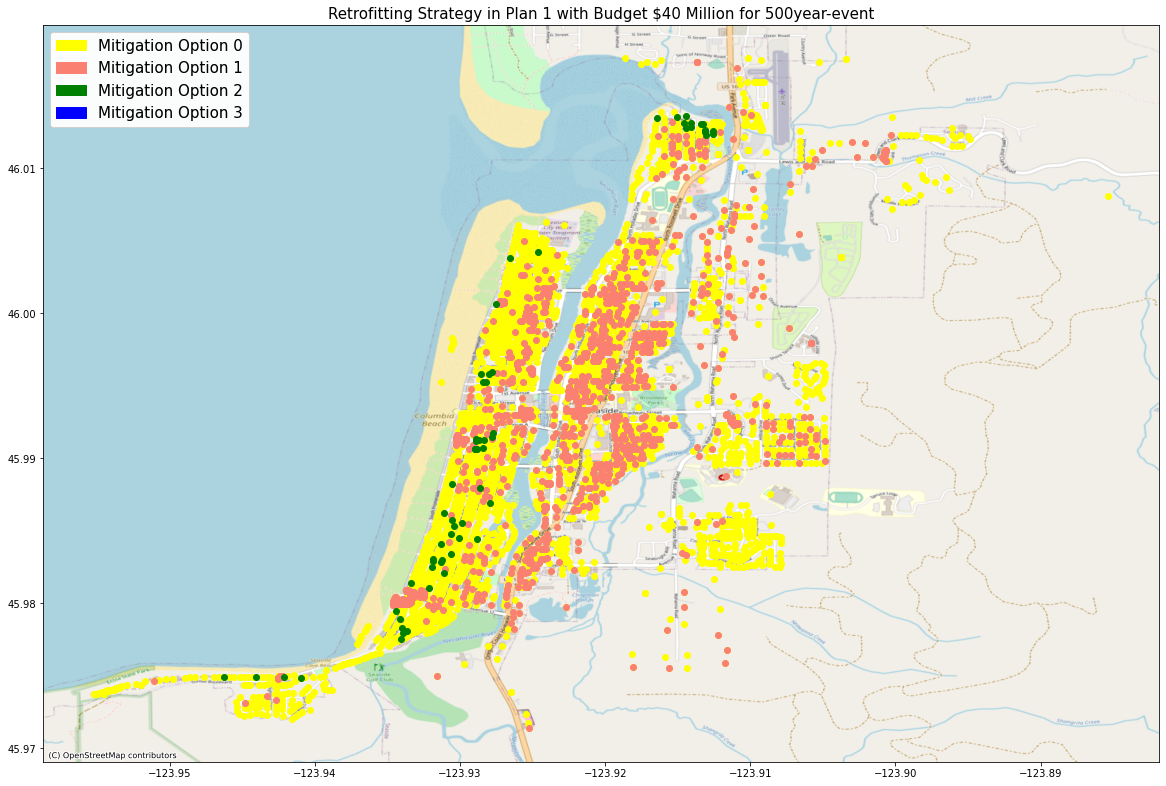

In [208]:
# --- making figure and map
fig, ax = plt.subplots(1,1)
gdf = gdf.to_crs(epsg=3857)

# plotting all parcels
gdf.plot(ax=ax, color='yellow')
abc = '500yr_solutions/decision_variable_B20_X1.csv'
# getting a subset of parcels
gdf_k1 = get_gdf_feats(gdf, path_to_run= abc , values=[1,2], k=[1])
gdf_k2 = get_gdf_feats(gdf, path_to_run= abc, values=[1,2], k=[2])
gdf_k3 = get_gdf_feats(gdf, path_to_run= abc, values=[1,2], k=[3])
# drawing the subset of parcels on the map
gdf_k1.plot(ax=ax, color='salmon')
gdf_k2.plot(ax=ax, color='green')
gdf_k3.plot(ax=ax, color='blue')
# adding basemap
#ctx.add_basemap(ax, zoom=15, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, zoom=15, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
p0 = mpatches.Patch(color='yellow')
p1 = mpatches.Patch(color='salmon')
p2 = mpatches.Patch(color='green')
p3 = mpatches.Patch(color='blue')
leg = plt.legend((p0,p1,p2,p3),('Mitigation Option 0','Mitigation Option 1','Mitigation Option 2', 'Mitigation Option 3'),loc="upper left",fontsize = 15)
ax.add_artist(leg);
ax.set_title("Retrofitting Strategy in Plan 1 with Budget $40 Million for 500year-event",fontsize = 15)